In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pickle
import os
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%matplotlib inline

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jhmoon/venvFL/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
with open('../Data/mHealth/mHealth_subject1.pickle', 'rb') as f:
    df = pickle.load(f)

In [7]:
df['label'].value_counts()

0.0     126106
8.0       3379
1.0       3072
2.0       3072
3.0       3072
4.0       3072
6.0       3072
7.0       3072
9.0       3072
10.0      3072
11.0      3072
5.0       3072
12.0      1075
Name: label, dtype: int64

In [9]:
from sklearn.utils import resample
 
df_majority = df[df.label==0]
df_minorities = df[df.label!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=3000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

8.0     3379
1.0     3072
2.0     3072
3.0     3072
4.0     3072
6.0     3072
7.0     3072
9.0     3072
10.0    3072
11.0    3072
5.0     3072
0.0     3000
12.0    1075
Name: label, dtype: int64

<AxesSubplot:>

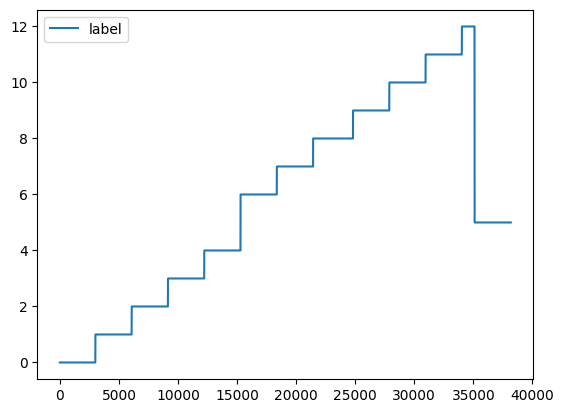

In [13]:
df[['label']].reset_index(drop=True).plot()

In [14]:
#Dropping feature have data outside 98% confidence interval
df1 = df.copy()
for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

xc_ACC range: -21.941 to 4.57132799999998
shape (37413, 24)
yc_ACC range: -4.187654 to 6.632435999999979
shape (36856, 24)
zc_ACC range: -12.08059 to 9.872354
shape (36230, 24)
ecg1 range: -2.2104 to 1.8796
shape (35648, 24)
ecg2 range: -5.581434 to 2.8310339999999865
shape (35338, 24)
xla_ACC range: -21.702 to 16.78269999999997
shape (34891, 24)
yla_ACC range: -19.445 to 2.9334279999998834
shape (34550, 24)
zla_ACC range: -19.14554 to 9.502060999999921
shape (34278, 24)
xla_GYR range: -0.79592 to 0.90353
shape (33581, 24)
yla_GYR range: -1.2083 to 0.66417
shape (33052, 24)
zla_GYR range: -1.0059 to 0.69745
shape (32514, 24)
xla_MAG range: -158.2354 to 220.01269999999997
shape (32054, 24)
yla_MAG range: -179.99810000000002 to 174.54969999999966
shape (31851, 24)
zla_MAG range: -172.9135 to 113.00699999999968
shape (31614, 24)
xrla_ACC range: -21.512 to 5.497065999999982
shape (31284, 24)
yrla_ACC range: -16.75443 to 13.182079999999987
shape (31046, 24)
zrla_ACC range: -10.27108 to 10.2

In [18]:
df1

,xc_ACC,yc_ACC,zc_ACC,ecg1,ecg2,xla_ACC,yla_ACC,zla_ACC,xla_GYR,yla_GYR,...,xrla_ACC,yrla_ACC,zrla_ACC,xrla_GYR,yrla_GYR,zrla_GYR,xrla_MAG,yrla_MAG,zrla_MAG,label
154060,-8.1302,-0.56142,-4.5137,0.020931,0.004186,-0.68636,-5.2902,4.64530,0.13544,-0.83114,...,-8.4230,-6.6402,2.980500,-0.939220,0.090349,0.21983,11.42200,-24.7380,5.8910,0.0
25011,-10.1300,1.93390,4.5635,-0.749350,-0.385140,1.61770,-5.7381,-15.39600,-0.29314,-1.03750,...,4.4382,5.8644,6.439100,0.039216,1.045200,0.33836,0.14330,14.3300,17.5490,0.0
860,-9.8035,0.27471,1.1089,0.004186,-0.020931,2.00960,-9.5485,0.59475,-0.11688,-0.86867,...,-3.5478,-9.2167,1.330800,0.172550,-1.082100,-0.31466,1.46680,3.0490,-2.1672,0.0
135796,-9.9147,-0.73211,-1.3501,0.435370,0.711670,3.10060,-10.3900,-1.35310,0.58070,-0.58349,...,-4.7630,-7.9758,0.424130,-0.484310,-0.694050,0.76078,-0.66111,-12.2510,-46.1000,0.0
142370,-6.2777,0.24763,-4.7777,-0.251180,-0.138150,-3.09580,-9.8328,-3.08510,0.84601,-0.36398,...,-6.0531,-8.0754,2.460800,-0.576470,-0.675560,0.62069,6.16500,6.0915,-1.7427,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160149,-7.9026,0.17872,-3.5523,-0.569340,-0.389320,5.52570,-11.3040,-5.67660,-0.75510,-1.05440,...,-1.8480,-8.5422,0.781220,-0.992160,-0.525670,-0.51078,8.67880,6.1191,39.8240,5.0
160150,-8.0657,-0.25192,-3.0753,-0.138150,-0.104660,2.33330,-9.3132,-5.57770,-0.75510,-1.05440,...,-2.1575,-8.1537,0.633980,-0.996080,-0.474330,-0.51509,7.79780,7.7898,42.6770,5.0
160151,-8.3670,-0.33493,-3.1565,-0.171640,-0.113030,0.16108,-10.3920,-7.54930,-0.79035,-1.06750,...,-2.4575,-7.8247,0.525430,-0.996080,-0.474330,-0.51509,7.42080,5.9969,44.4930,5.0
160152,-8.5282,-0.35852,-2.9796,-0.150710,-0.079540,-0.13053,-11.5280,-8.25480,-0.79035,-1.06750,...,-2.1839,-7.6266,0.337420,-0.996080,-0.474330,-0.51509,6.32390,4.0223,45.5740,5.0
